In [6]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
import math
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\AAM\False Rejects")

In [8]:
df=pd.read_pickle(os.getcwd()+"\Data Files\Transformed_NVH_DATA.pkl")

In [9]:
df.head(5)

CHARDESC,SITENAME,LINENAME,STATIONNAME,PARTNUMBER,STATUS,TOPLEVELSERIALNUMBER,PROD_TIMESTAMP,COLLID,LH Slide To Full Depth Posn,NVH Torque Sweep Test Cycle Count,Pinion Slide To Full Depth Posn,RH Slide To Full Depth Posn,FALSE_REJECT
12,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A192630807,2020-03-26 08:18:37.623,-1254007092,1095.29,1.0,245.400,1498.46,0
13,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A192660476,2020-03-26 08:20:27.887,-1254006657,1095.39,1.0,245.607,1498.17,0
14,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A192660506,2020-03-26 08:14:33.793,-1254007456,1095.69,1.0,245.698,1498.30,0
15,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A192660555,2020-03-26 08:16:38.367,-1254007093,1095.20,1.0,245.470,1497.36,0
18264,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A200630110,2020-06-05 00:45:35.833,-1251008204,1095.40,1.0,246.075,1497.79,0


In [10]:
df.sort_values(by = 'PROD_TIMESTAMP', inplace = True)

df = df[df["STATIONNAME"]=="OP180B"]

In [11]:
df.PROD_TIMESTAMP.dt.month.value_counts().sort_index()

3     3163
5     2099
6    18178
7    18197
Name: PROD_TIMESTAMP, dtype: int64

In [12]:
df["PROD_DAY"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day))

In [13]:
df_dod = df[["PROD_DAY","FALSE_REJECT"]].groupby("PROD_DAY").agg(["sum","count"]).reset_index()
df_dod.columns = [' '.join(col).strip() for col in df_dod.columns.values]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


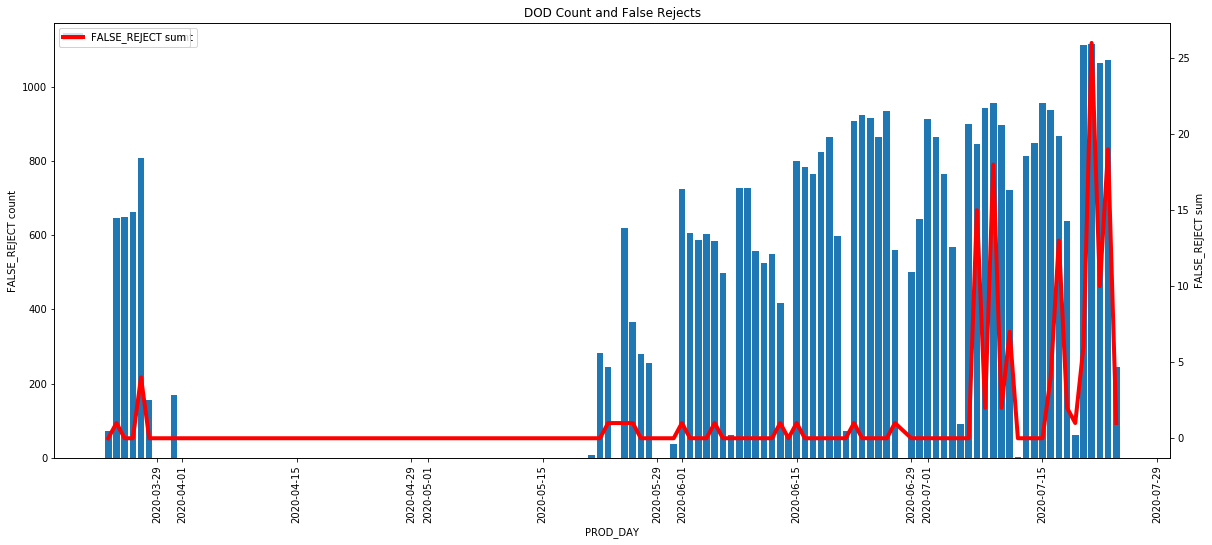

In [14]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(df_dod["PROD_DAY"],df_dod["FALSE_REJECT count"], label = 'FALSE_REJECT count')
plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT count')
plt.legend(loc="best")
plt.xticks(rotation = 90,)
ax2 = ax1.twinx()
ax2.plot(df_dod["PROD_DAY"],df_dod["FALSE_REJECT sum"],color='red', linewidth=4, markersize=12, label = 'FALSE_REJECT sum')
plt.title("DOD Count and False Rejects")
plt.legend(loc="best")


plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT sum')

plt.show()
# ax1.plot()

# df_dod.plot(x="PROD_DAY", y = ["FALSE_REJECT sum","FALSE_REJECT count"])

In [15]:
df= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,1))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))]


(array([737577., 737584., 737591., 737598., 737605., 737607., 737614.,
        737621., 737628.]), <a list of 9 Text xticklabel objects>)

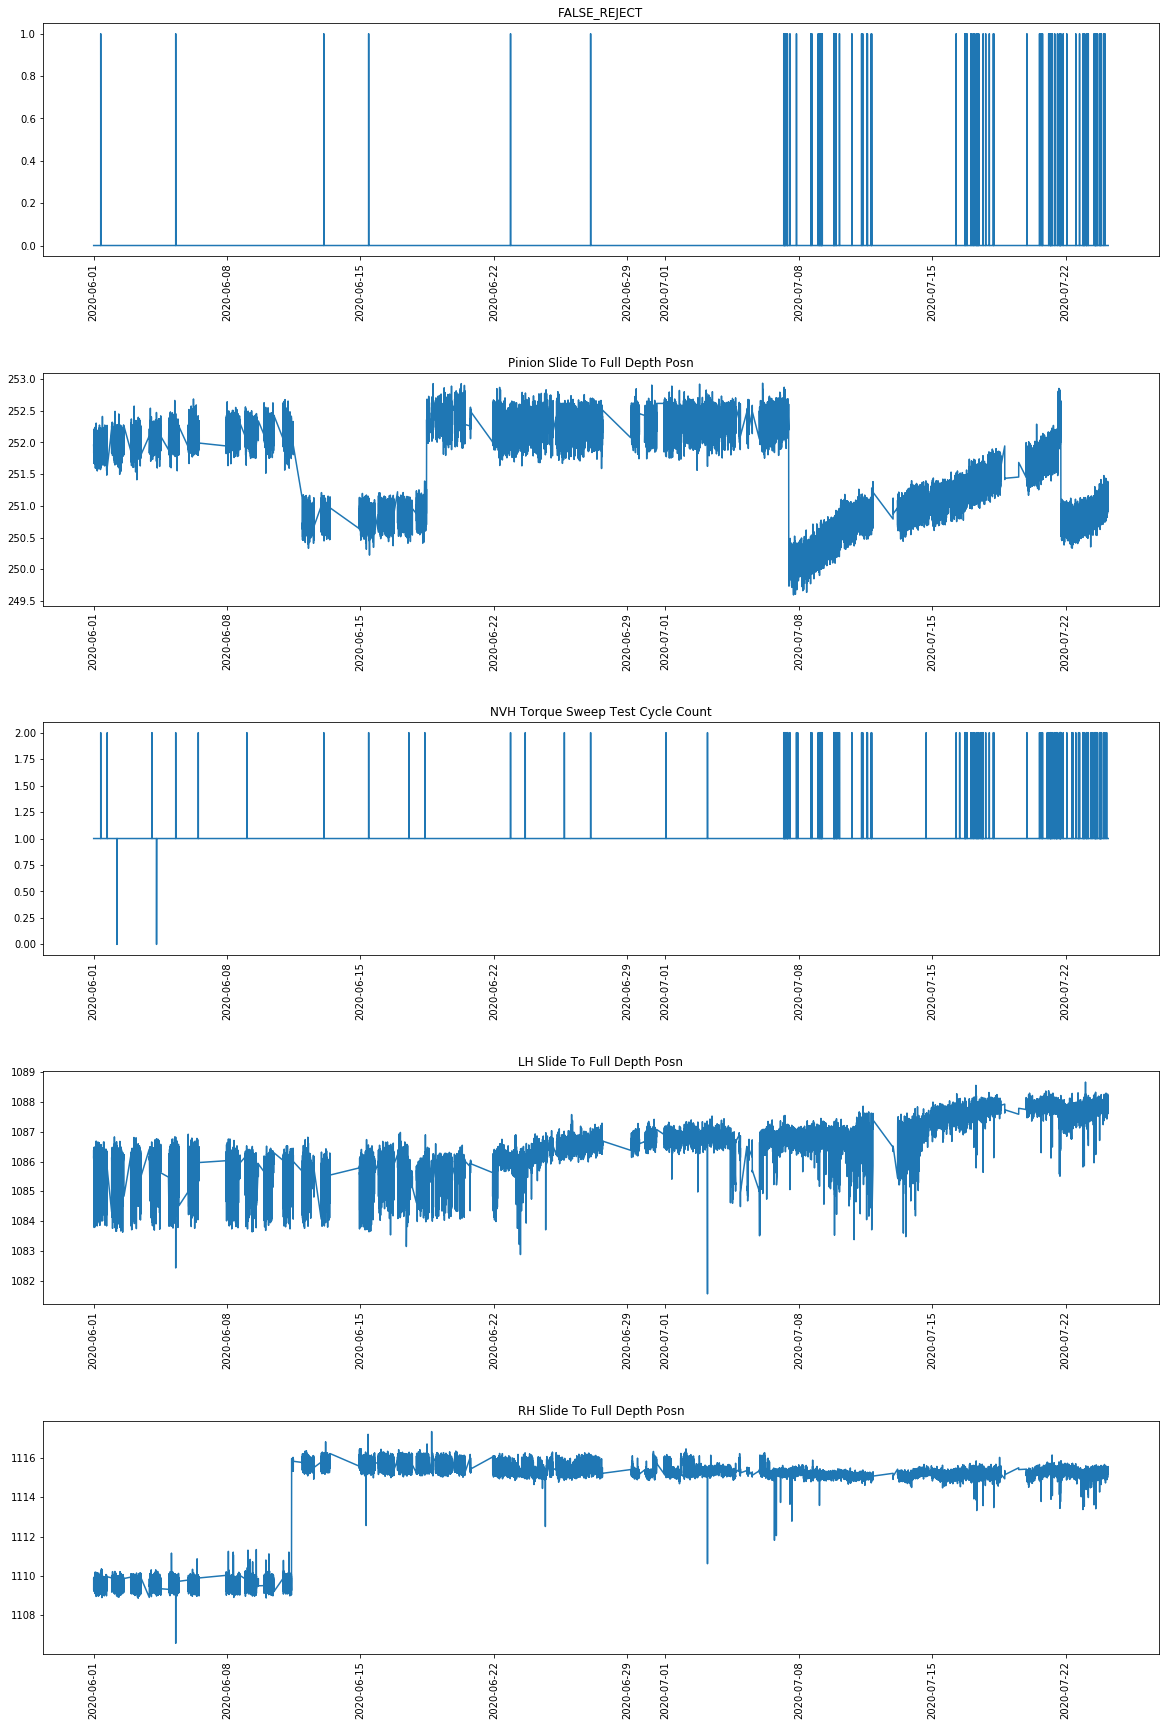

In [16]:
df1= df
# df1= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,22))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,6,25))]
df1= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,1))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))]

fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["Pinion Slide To Full Depth Posn"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_TIMESTAMP"],df1["NVH Torque Sweep Test Cycle Count"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_TIMESTAMP"],df1["LH Slide To Full Depth Posn"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_TIMESTAMP"],df1["RH Slide To Full Depth Posn"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


# Group on hourly level and plot

In [17]:
df["PROD_HOUR"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day,x.hour))

In [18]:
df_hour = df[["PROD_HOUR","LH Slide To Full Depth Posn","NVH Torque Sweep Test Cycle Count","Pinion Slide To Full Depth Posn","RH Slide To Full Depth Posn","FALSE_REJECT"]].groupby("PROD_HOUR").agg(["mean"])

df_hour.columns = [' '.join(col).strip() for col in df_hour.columns.values]

df_hour.reset_index(inplace = True)

In [19]:
df.PROD_HOUR.dt.week.value_counts().sort_index()

23    3665
24    3563
25    4702
26    5104
27    4346
28    5265
29    5124
30    4606
Name: PROD_HOUR, dtype: int64

(array([737577., 737584., 737591., 737598., 737605., 737607., 737614.,
        737621., 737628.]), <a list of 9 Text xticklabel objects>)

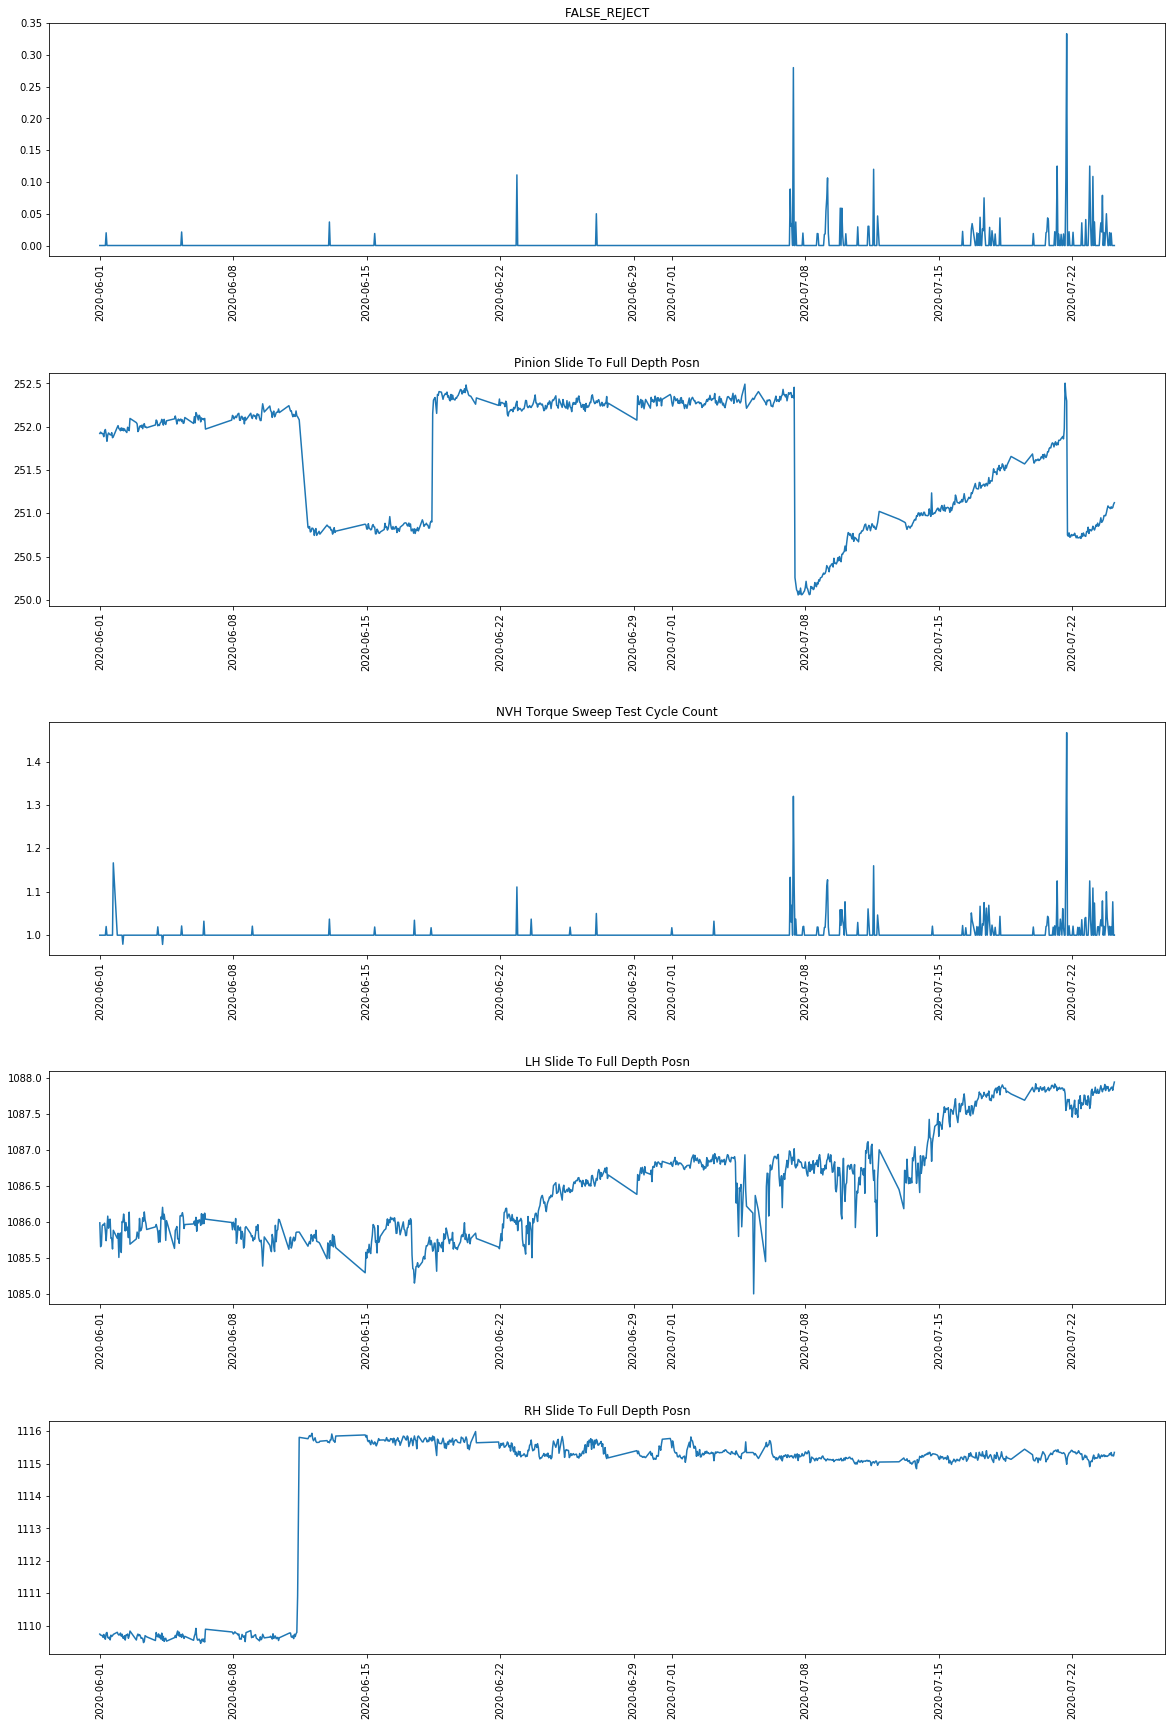

In [20]:
df1= df_hour[df_hour["PROD_HOUR"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_HOUR"],df1["FALSE_REJECT mean"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_HOUR"],df1["Pinion Slide To Full Depth Posn mean"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_HOUR"],df1["NVH Torque Sweep Test Cycle Count mean"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_HOUR"],df1["LH Slide To Full Depth Posn mean"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_HOUR"],df1["RH Slide To Full Depth Posn mean"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


# Group on 6 hourly level and plot

In [21]:
df["PROD_HOUR"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day,math.floor(x.hour/6)*6))

In [22]:
df_hour = df[["PROD_HOUR","LH Slide To Full Depth Posn","NVH Torque Sweep Test Cycle Count","Pinion Slide To Full Depth Posn","RH Slide To Full Depth Posn","FALSE_REJECT"]].groupby("PROD_HOUR").agg(["mean"])

df_hour.columns = [' '.join(col).strip() for col in df_hour.columns.values]

df_hour.reset_index(inplace = True)

(array([737577., 737584., 737591., 737598., 737605., 737607., 737614.,
        737621., 737628.]), <a list of 9 Text xticklabel objects>)

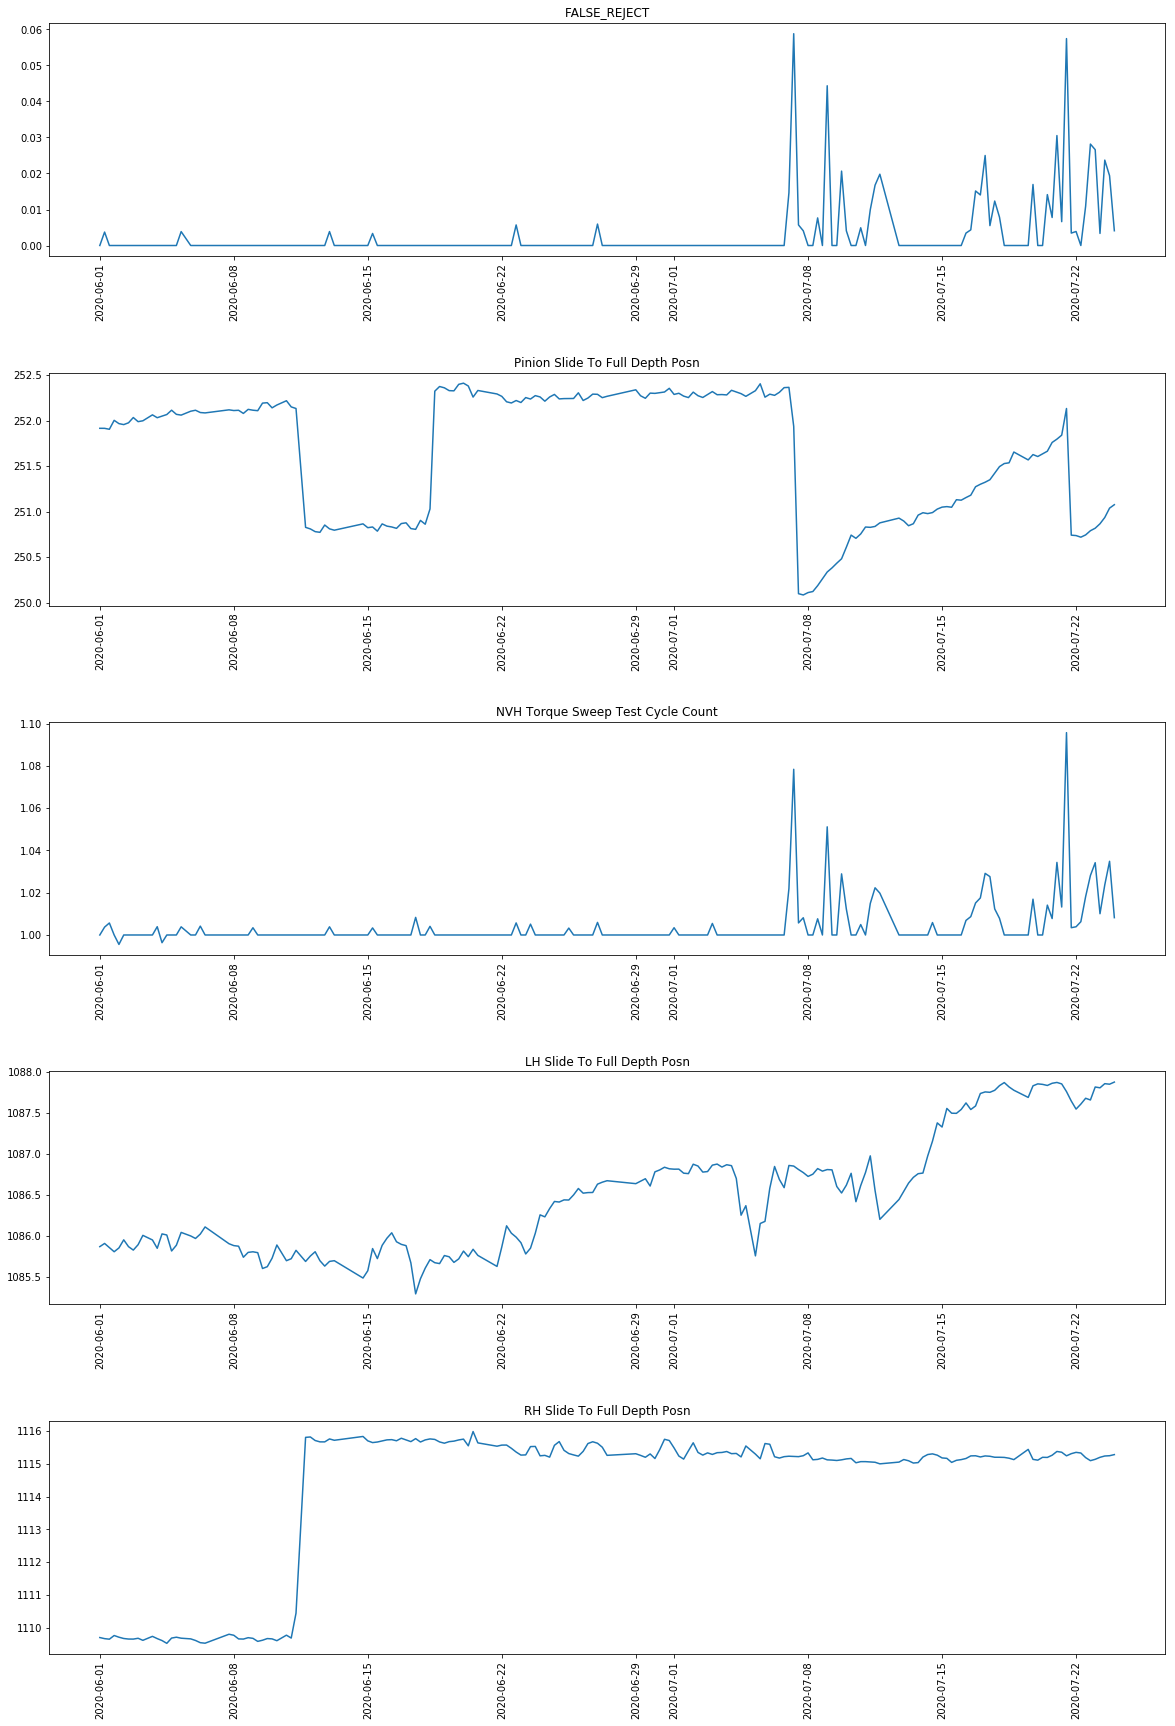

In [23]:
df1= df_hour[df_hour["PROD_HOUR"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_HOUR"],df1["FALSE_REJECT mean"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_HOUR"],df1["Pinion Slide To Full Depth Posn mean"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_HOUR"],df1["NVH Torque Sweep Test Cycle Count mean"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_HOUR"],df1["LH Slide To Full Depth Posn mean"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_HOUR"],df1["RH Slide To Full Depth Posn mean"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


# Anamoly Score implementation

# Using Robust Random cut Forest

In [24]:
sin = df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,1))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))][["PROD_TIMESTAMP","FALSE_REJECT"]]

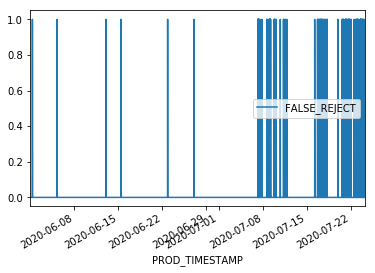

In [25]:
sin.plot(x="PROD_TIMESTAMP",y="FALSE_REJECT")

In [26]:
import rrcf

num_trees = 40
shingle_size =1500
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [27]:
points = rrcf.shingle(sin["FALSE_REJECT"], size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # And take the average over all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees

In [28]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax1 = plt.subplots(figsize=(10, 5))


# color = 'tab:red'
# ax1.set_ylabel('Data', color=color, size=14)
# ax1.plot(sin, color=color)
# ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
# ax1.set_ylim(0,5)
# ax2 = ax1.twinx()
# color = 'tab:blue'
# ax2.set_ylabel('CoDisp', color=color, size=14)
# ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
# ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
# ax2.grid('off')
# ax2.set_ylim(0, 500)
# plt.title('False Reject (red) and anomaly score (blue)', size=14)

(array([737577., 737584., 737591., 737598., 737605., 737607., 737614.,
        737621., 737628.]), <a list of 9 Text xticklabel objects>)

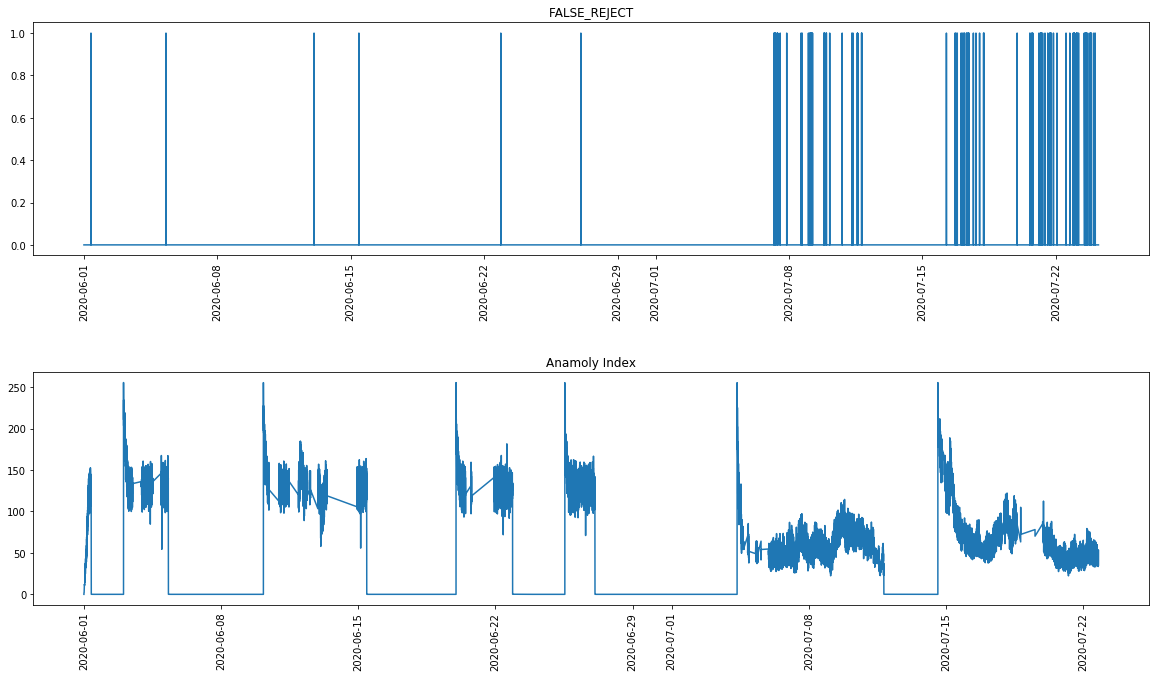

In [29]:

fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(sin["PROD_TIMESTAMP"],sin["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(sin["PROD_TIMESTAMP"][0:len(sin)-shingle_size+1],pd.Series(avg_codisp))
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


# Using distribution comparison 2 Sample KS Statistics

## False Reject

In [30]:
# df.reset_index(inplace = True)
df["DIFF"] = ""

# x= 20000
b_window = 6000  #Remove identified anamolies
c_window = 30


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = list(df["FALSE_REJECT"][max(0,x-b_window-c_window):max(0,x-c_window)])
    current_obs = list(df["FALSE_REJECT"][max(0,x-c_window):x])
    ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
    df.loc[df.index[x],"DIFF"] = 1-ks_value.pvalue

print (time.time()-start)

NameError: name 'ks_2samp' is not defined

In [ ]:
df1 = df.dropna(subset = ['DIFF'])
df1 = df[df["DIFF"]!=""]
# df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["DIFF"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


## Pinion Slide To Full Depth Posn

In [ ]:
# df.reset_index(inplace = True)
df["DIFF_VAR1"] = ""

# x= 20000
b_window = 6000
c_window = 30


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
    current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
    ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
    df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue

print (time.time()-start)

In [ ]:
df1 = df.dropna(subset = ['DIFF_VAR1'])
df1 = df[df["DIFF_VAR1"]!=""]
df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["DIFF_VAR1"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


# Using distribution comparison Chi Square

## False Reject

In [ ]:
# df.reset_index(inplace = True)

# x= 20000
b_window = 6000
c_window = 500
gap = 6000


start = time.time()

for x in range(b_window+gap,df.shape[0]):
    base_obs = list(df["FALSE_REJECT"][max(0,x-b_window-c_window-gap):max(0,x-c_window-gap)])
    current_obs = list(df["FALSE_REJECT"][max(0,x-c_window):x])
#     table = [[base_obs.count(0), base_obs.count(1)],
#         [current_obs.count(0),current_obs.count(1)]]

    table = [[2000, 60],
        [current_obs.count(0),current_obs.count(1)]]

    
    try:

        stat, p, dof, expected = chi2_contingency(table)
#     ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
        df.loc[df.index[x],"CHI_SQ_1"] = 1-p
    except:
        df.loc[df.index[x],"CHI_SQ_1"] = 0
        
print (time.time()-start)

In [ ]:
df1 = df.dropna(subset = ['CHI_SQ_1'])
df1 = df[df["CHI_SQ_1"]!=""]
# df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["CHI_SQ_1"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


In [ ]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(df_dod["PROD_DAY"],df_dod["FALSE_REJECT count"], label = 'FALSE_REJECT count')
plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT count')
plt.legend(loc="best")
plt.xticks(rotation = 90,)
ax2 = ax1.twinx()
ax2.plot(df_dod["PROD_DAY"],df_dod["FALSE_REJECT sum"],color='red', linewidth=4, markersize=12, label = 'FALSE_REJECT sum')
plt.title("DOD Count and False Rejects")
plt.legend(loc="best")


plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT sum')

plt.show()
# ax1.plot()

# df_dod.plot(x="PROD_DAY", y = ["FALSE_REJECT sum","FALSE_REJECT count"])